<a href="https://colab.research.google.com/github/Digx1/langgraph-notes/blob/main/module-3/streaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


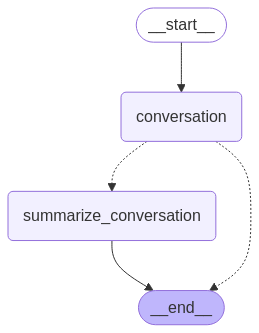

In [3]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

# State
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Digvijay")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello, Digvijay! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 14, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-b4e45219-ffe9-4964-8e3b-887033c4f621-0', usage_metadata={'input_tokens': 14, 'output_tokens': 15, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [6]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm digvijay")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()


================================== Ai Message ==================================

Hello, Digvijay! How can I assist you today?


In [7]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Digvijay")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Digvijay
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Digvijay
================================== Ai Message ==================================

Hello, Digvijay! How can I assist you today?
---------------------------------------------------------------------------


In [9]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about india")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_start. Name: _write
Node: __start__. Type: on_chain_end. Name: _write
Node: __start__. Type: on_chain_start. Name: _write
Node: __start__. Type: on_chain_end. Name: _write
Node: __start__. Type: on_chain_stream. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: 

In [10]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about india")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-c0e962f8-97d4-42af-a7b6-916a28e048c2')}
{'chunk': AIMessageChunk(content='India', additional_kwargs={}, response_metadata={}, id='run-c0e962f8-97d4-42af-a7b6-916a28e048c2')}
{'chunk': AIMessageChunk(content=' is', additional_kwargs={}, response_metadata={}, id='run-c0e962f8-97d4-42af-a7b6-916a28e048c2')}
{'chunk': AIMessageChunk(content=' a', additional_kwargs={}, response_metadata={}, id='run-c0e962f8-97d4-42af-a7b6-916a28e048c2')}
{'chunk': AIMessageChunk(content=' diverse', additional_kwargs={}, response_metadata={}, id='run-c0e962f8-97d4-42af-a7b6-916a28e048c2')}
{'chunk': AIMessageChunk(content=' and', additional_kwargs={}, response_metadata={}, id='run-c0e962f8-97d4-42af-a7b6-916a28e048c2')}
{'chunk': AIMessageChunk(content=' culturally', additional_kwargs={}, response_metadata={}, id='run-c0e962f8-97d4-42af-a7b6-916a28e048c2')}
{'chunk': AIMessageChunk(content=' rich', additional_kwargs={}, 

In [13]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the india!")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|Certainly|!| Here's| an| overview| of| India|:

|###| Geography|
|-| **|Location|**|:| India| is| located| in| South| Asia| and| is| bordered| by| Pakistan| to| the| northwest|,| China| and| Nepal| to| the| north|,| Bhutan| to| the| northeast|,| and| Bangladesh| and| Myanmar| to| the| east|.| To| the| south|,| it| is| bounded| by| the| Indian| Ocean|.
|-| **|Size|**|:| It| is| the| seventh|-largest| country| in| the| world| by| land| area|.
|-| **|Landscape|**|:| India| features| diverse| landscapes|,| including| the| Himalayan| mountain| range| in| the| north|,| the| Th|ar| Desert| in| the| west|,| fertile| plains|,| and| a| long| coastline| with| beautiful| beaches|.

|###| Population|
|-| **|Population|**|:| India| is| the| second|-most| populous| country| in| the| world|,| with| over| |1|.|4| billion| people|.
|-| **|D|iversity|**|:| The| country| is| known| for| its| ethnic|,| linguistic|,| and| cultural| diversity|.| It| is| home| to| numerous| ethnic| groups| and| more| than| |